## Noisy RGB pixels, Conv + UNet + Residual + Conv + Residual, 1/8 U-Net bottleneck, L1/L2 + Perceptual + Adversarial + Color Correction Loss

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
from plot_data import load_data

import oidn.wrapper
import importlib
importlib.reload(oidn.wrapper)
oidn_model = oidn.wrapper.load_model()


def plot_frame(frame):
    if frame.shape[0] == 1:
        frame = np.repeat(frame, 3, 0)
    frame = np.clip(frame, 0.0, 1.0)
    frame = np.einsum('kij->ijk', np.flip(frame, axis=1))
    plt.figure()
    plt.imshow(frame)
    plt.show()


def load_data_file(filename, verbose=False):
    bufferview = load_data(filename)
    images = {}
    img_sum = 0.0 * bufferview[0]['buffer']
    w = 0.0
    for image in bufferview:
        images[image['name']] = image['buffer']
        if not image['name'] >= 1:
            continue
        w += image['name']
        img_sum += image['name'] * image['buffer']

    # noise images less than 1spp
    sub = []
    for e in range(1, 4+1, 1):
        spp = 2**(-e)
        if spp not in images:
            break
        img = np.nan_to_num(images[spp], nan=0.0, posinf=0.0, neginf=0.0)
        sub.append(img)

    # power of 2 images greater than 1spp
    data = []
    for e in range(0, len(images)-len(sub)):
        spp = 2**e
        if spp not in images:
            break
        data.append(images[spp])
    data = np.array(data)
    data = np.nan_to_num(data, nan=0.0, posinf=0.0, neginf=0.0)

    # reference image, denoise with oidn
    ref = img_sum / w
    with torch.no_grad():
        x = ref.reshape((1, *ref.shape))
        x = np.fmax(x, 0.0) ** (1.0/2.2)
        x = torch.tensor(x).to(device)
        y = oidn_model(x)
        ref = np.fmax(y[0].cpu().numpy(), 0.0) ** 2.2

    if verbose:
        print(len(sub), data.shape, data.dtype, ref.shape, ref.dtype)
        plot_frame(ref**(1.0/2.2))
    return {
        'sub': sub,
        'data': data,
        'ref': ref
    }

# _ = load_data_file("data/implicit3-rt_0c2c00f9b182_1024.bin", verbose=True)

In [3]:
import random

class RawDataset(torch.utils.data.Dataset):
    def __init__(self, n):
        import os
        self.data = []
        for root, dirs, files in os.walk('data/'):
            for filename in files:
                filename = os.path.join(root, filename)
                try:
                    self.data.append(load_data_file(filename))
                except:
                    pass
        self.n = n
    
    def __len__(self):
        return self.n

    def __getitem__(self, i):

        # random data
        img = self.data[random.randint(0,len(self.data)-1)]
        clean = img['ref']

        # random chance to get <1spp image
        if random.random() < 0.0:
            noisy = random.choice(img['sub'])

        # clean image - random spp, sample from spp
        else:
            n = img['data'].shape[0]
            spp = max(round(0.6 * np.random.random()**4 * 2**n), 1)
            total = 0.0
            weight = 0.0
            for _ in range(n):
                if (spp >> _) & 1 == 0:
                    continue
                frame = img['data'][_]
                dw = ((frame > 0.0) & (frame < 1e6)).astype(np.float32) * 2**_
                total += frame * dw
                weight += dw
            noisy = total / np.fmax(weight, 1.0)

        # random flip/rotate/transpose
        if random.random() < 0.5:
            noisy = np.flip(noisy, 0)
            clean  = np.flip(clean,  0)
        if random.random() < 0.5:
            noisy = np.flip(noisy, 1)
            clean = np.flip(clean, 1)
        if random.random() < 0.5:
            noisy = np.swapaxes(noisy,  1, 2)
            clean = np.swapaxes(clean, 1, 2)

        # random swap color channels
        cidx = [0, 1, 2]
        random.shuffle(cidx)
        noisy = noisy[cidx]
        clean = clean[cidx]

        return [
            np.fmax(noisy, 0.0) ** (1.0/2.2),
            np.fmax(clean, 0.0) ** (1.0/2.2)
        ]


def plot_imgs(x):
    plt.figure()
    x = torch.clip(x, 0.0, 1.0)
    x = torch.flip(x, [2])
    plt.imshow(np.transpose(vutils.make_grid(x[:8].cpu(),
        nrow=4, padding=2, pad_value=1, normalize=True), (1, 2, 0)),
                interpolation='nearest')
    plt.axis("off")
    plt.show()

for x, y in torch.utils.data.DataLoader(
    RawDataset(128),
    batch_size=8,
    shuffle=True
):
    break

print(x.shape)
plot_imgs(x)
plot_imgs(y)

torch.Size([8, 3, 256, 256])


In [4]:
def conv3(nin, nout):
    return torch.nn.Conv2d(nin, nout, 3, padding=1, bias=True, padding_mode="reflect")

def conv1(nin, nout):
    return torch.nn.Conv2d(nin, nout, 1, padding=0, bias=True)

def dconv4(nin, nout):
    return torch.nn.ConvTranspose2d(nin, nout, 4, 2, 1, bias=True)

def prelu(n):
    return torch.nn.PReLU(n)

def relu(x, inplace=True):
    return F.relu(x, inplace)

def pool(x):
    return F.max_pool2d(x, 2)

def concat(a, b):
    return torch.concat((a, b), axis=1)

class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        n0 = 12
        n1 = 16
        n2 = 24
        n3 = 32
        self.convi = conv3(3, n0)
        self.relui = prelu(n0)
        self.econv0a = conv3(n0, n0) # 1
        self.relue0 = prelu(n0)
        self.econv0b = conv3(n0, n0) # 1
        self.econv1a = conv3(n0, n1) # 1/2
        self.relue1 = prelu(n1)
        self.econv1b = conv3(n1, n1) # 1/2
        self.econv2a = conv3(n1, n2) # 1/4
        self.relue2 = prelu(n2)
        self.econv2b = conv3(n2, n2) # 1/4
        self.econv3a = conv3(n2, n3) # 1/8
        self.relue3 = prelu(n3)
        self.econv3b = conv3(n3, n3) # 1/8
        self.relum = prelu(n3)
        self.dconv2a = dconv4(n3, n2) # 1/8->1/4
        self.relud2a = prelu(n2)
        self.dconv2b = conv1(n2+n2, n2) # 1/4
        self.dconv1a = dconv4(n2, n1) # 1/4->1/2
        self.relud1a = prelu(n1)
        self.dconv1b = conv1(n1+n1, n1) # 1/2
        self.dconv0a = dconv4(n1, n0) # 1/2->1
        self.relud0a = prelu(n0)
        self.dconv0b = conv1(n0+n0, n0) # 1
        self.convo1 = conv1(n0, n0)
        self.convo2 = conv1(n0, 3)

    def forward(self, xi):
        ci = self.convi(xi)
        cir = self.relui(ci)
        e0 = self.econv0b(self.relue0(self.econv0a(cir))) # 1
        e1 = self.econv1b(self.relue1(self.econv1a(pool(e0)))) # 1/2
        e2 = self.econv2b(self.relue2(self.econv2a(pool(e1)))) # 1/4
        e3 = self.econv3b(self.relue3(self.econv3a(pool(e2)))) # 1/8
        d2 = self.relud2a(self.dconv2a(self.relum(e3))) # 1/4
        d2 = relu(self.dconv2b(concat(d2, e2))) # 1/4
        d1 = self.relud1a(self.dconv1a(d2)) # 1/2
        d1 = relu(self.dconv1b(concat(d1, e1))) # 1/2
        d0 = self.relud0a(self.dconv0a(d1)) # 1
        do = relu(self.dconv0b(concat(d0, e0))) # 1
        xo = self.convo2(relu(self.convo1(ci+do)))+xi
        return xo


model = Model().to(device)
x = torch.randn((8, 3, 256, 256), device=device)
with torch.no_grad():
    y = model(x)
print(y.shape)

print(model)

torch.Size([8, 3, 256, 256])
Model(
  (convi): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (relui): PReLU(num_parameters=12)
  (econv0a): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (relue0): PReLU(num_parameters=12)
  (econv0b): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (econv1a): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (relue1): PReLU(num_parameters=16)
  (econv1b): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (econv2a): Conv2d(16, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (relue2): PReLU(num_parameters=24)
  (econv2b): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (econv3a): Conv2d(24, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  (relue3): 

In [5]:
"""Image Denoising Using A Generative Adversarial Network,
    Code modified from implementation by Jeffrey Ming Han Li"""

class Discriminator(torch.nn.Module):
    def __init__(self,K2):
        super(Discriminator, self).__init__()

        # Basic convolutional block
        def conv_block(in_channels, out_channels, kernel_size, stride):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding=1),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.LeakyReLU(0.01, inplace=True)
            )
        def last_block(in_channels, out_channels, kernel_size, stride):
            return torch.nn.Sequential(
                torch.nn.Conv2d(in_channels,out_channels,kernel_size,stride,1),
                torch.nn.BatchNorm2d(out_channels),
                torch.nn.Sigmoid()
            )

        self.model = torch.nn.Sequential(
            conv_block(3,K2, kernel_size=4, stride=2),
            conv_block(K2,3*K2//2, kernel_size=4, stride=2),
            conv_block(3*K2//2,K2*2, kernel_size=4, stride=2),
            conv_block(K2*2,K2*3, kernel_size=4, stride=2),
            conv_block(K2*3,K2*4, kernel_size=4, stride=2),
            conv_block(K2*4,K2*4, kernel_size=3, stride=1),
            last_block(K2*4,1, kernel_size=3, stride=1)
        )

    def forward(self, x):
        y = self.model(x)
        # print(y.shape)
        return torch.clip(torch.mean(y, axis=(2, 3)), 0.0, 1.0)


class CombinedLoss(torch.nn.Module):
    def __init__(self, lambda_a, lambda_p, lambda_f, lambda_c, device='cpu'):
        super(CombinedLoss, self).__init__()
        self.lambda_a = lambda_a  # adversarial
        self.lambda_p = lambda_p  # pixel loss
        self.lambda_f = lambda_f  # feature loss (perceptual)
        # self.lambda_t = lambda_t  # texture matching loss
        self.lambda_t = 0.0
        self.lambda_c = lambda_c  # correct color shift caused by GAN

        # loss function for GAN
        self.bce = torch.nn.BCEWithLogitsLoss()

        # VGG16 model for feature and texture loss
        import torchvision.models
        vgg16 = torchvision.models.vgg16(weights='VGG16_Weights.DEFAULT')
        vgg_mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
        vgg_std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)

        # vgg first layer
        self.feature_extractor = vgg16.features[:4].to(device)
        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        self.feature_extractor_1 = lambda x: self.feature_extractor((x-vgg_mean)/vgg_std)
        # print(self.feature_extractor)

        # vgg second layer, after first layer
        self.feature_extractor_2 = vgg16.features[4:9].to(device)
        for param in self.feature_extractor_2.parameters():
            param.requires_grad = False
        # print(self.feature_extractor_2)
    
    @staticmethod
    def gram(x, s):
        if x.shape[2] % s != 0 or x.shape[3] % s != 0:
            raise ValueError("Image dimension not multiple of texture patch size")
        x = x.view(x.shape[0], x.shape[1], x.shape[2]//s, s, x.shape[3]//s, s)
        x = x.permute(0, 1, 2, 4, 3, 5).contiguous()
        x = x.view(x.shape[0], x.shape[1], -1, s*s)
        g = torch.matmul(x, x.transpose(3, 2))
        return g / (s*s)
    
    @staticmethod
    def mask_non_finite(x, v):
        nan_mask = torch.isnan(x)
        inf_mask = torch.isinf(x)
        x[nan_mask] = v
        x[inf_mask] = v
        return x
    
    def forward(self, generated, target, discriminator_output, is_discriminator=False):
        # normalization parameters
        normalize_l2 = 1.0 / 0.05  # change this to estimated L1 loss
        normalize_vgg = 1.0 / 0.225
        normalize_l2_vgg = normalize_l2 / normalize_vgg
        normalize_l2_vgg_gram = normalize_l2_vgg ** 2

        # adversarial Loss
        if is_discriminator:
            return self.bce(discriminator_output, target)
        # loss_a = -torch.mean(discriminator_output)
        loss_a = self.bce(1.0-discriminator_output, torch.ones_like(discriminator_output))

        # pixel loss (L1+L2)
        loss_p2 = torch.mean((generated-target)**2) * normalize_l2
        loss_p1 = torch.mean(torch.abs(generated-target))
        loss_p = 0.5*(loss_p1+loss_p2)

        # feature loss (L1+L2)
        gen_features = self.feature_extractor_1(generated)
        tgt_features = self.feature_extractor_1(target)
        loss_f1l2 = torch.mean((gen_features-tgt_features)**2) * normalize_l2_vgg
        loss_f1l1 = torch.mean(torch.abs(gen_features-tgt_features))
        gen_features_2 = self.feature_extractor_2(gen_features)
        tgt_features_2 = self.feature_extractor_2(tgt_features)
        loss_f2l2 = torch.mean((gen_features_2-tgt_features_2)**2) * normalize_l2_vgg
        loss_f2l1 = torch.mean(torch.abs(gen_features_2-tgt_features_2))
        loss_f = 0.25*(loss_f1l2+loss_f1l1+loss_f2l2+loss_f2l1)

        # texture loss
        # loss_t1 = torch.mean(self.gram(gen_features,16)-self.gram(tgt_features,16))**2
        # # loss_t2 = torch.mean(self.gram(gen_features_2,8)-self.gram(tgt_features_2,8))**2
        # loss_t2 = torch.mean(self.gram(gen_features_2,16)-self.gram(tgt_features_2,16))**2
        # loss_t = (0.5*(loss_t1+loss_t2))**0.5 * normalize_l2_vgg_gram
        loss_t = 0.0

        # color correction loss
        output_size = (7, 7)  # non power of 2 to break tiles
        generated_mapped = torch.nn.functional.interpolate(
            torch.clip(torch.exp(generated)-1.0,0.0,1e3)**2.2, output_size, mode="bilinear")
        target_mapped = torch.nn.functional.interpolate(
            torch.clip(torch.exp(target)-1.0,0.0,1e3)**2.2, output_size, mode="bilinear")
        generated_mapped = self.mask_non_finite(generated_mapped, 0.0)
        target_mapped = self.mask_non_finite(target_mapped, 0.0)
        eps = 0.01
        loss_c_log = torch.mean(
            generated_mapped/(target_mapped+eps) + \
            target_mapped/(generated_mapped+eps) - 2.0
        ) * normalize_l2
        loss_c_l2 = torch.mean(torch.log((generated_mapped-target_mapped)**2+1.0)) * normalize_l2
        loss_c_l1 = torch.mean(torch.log(torch.abs(generated_mapped-target_mapped)+1.0))
        loss_c = 0.4*loss_c_log + 0.3*loss_c_l2 + 0.3*loss_c_l1

        # composite loss
        total_loss = \
            self.lambda_a * loss_a + \
            self.lambda_p * loss_p + \
            self.lambda_f * loss_f + \
            self.lambda_t * loss_t + \
            self.lambda_c * loss_c
        # print(loss_a.item(), loss_p.item(), loss_f.item(), loss_t.item(), loss_c.item())

        return total_loss


discriminator = Discriminator(16).to(device)
print(discriminator)

Discriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(16, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(24, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(32, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(

In [6]:
from torch.optim import lr_scheduler

optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
optimizer_d = torch.optim.Adam(discriminator.parameters(), lr = 0.005)
scheduler = lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.3, patience=10, min_lr=0.00005)
scheduler_d = lr_scheduler.ReduceLROnPlateau(
    optimizer_d, mode='min', factor=0.3, patience=10, min_lr=0.0001)

enable_epoch = 32

# model 0: (0.5, 1.0, 1.0, 0.3), lr=(0.002,0.002), f=0.3, mlr=(0.00005,0.0001)
# model 1: (1.0, 1.0, 1.0, 0.2), lr=(0.002,0.002), f=0.3, mlr=(0.00005,0.0001)
# model 2: (1.0, 1.0, 1.0, 0.3), lr=(0.002,0.005), f=0.3, mlr=(0.0001,0.0001), ee=32
lossfun = CombinedLoss(0.0, 1.0, 1.0, 0.3, device)

Ready
1 g 5.901223456859588 4.388044491410255 d 1.4377757221460346 1.4316160380840302
2 g 2.7139239877462384 1.8890205919742584 d 1.4267202854156495 1.4218580424785614
3 g 1.7795537054538728 1.6112610697746277 d 1.4186557441949843 1.4151189923286438
4 g 1.581445325911045 1.4965029433369637 d 1.4122806310653684 1.4095199704170227
5 g 1.4722676977515223 1.5041481629014015 d 1.4072831302881237 1.4051569700241089
6 g 1.4017388895154 1.4947730712592602 d 1.4038009911775586 1.4022187441587448
7 g 1.2799964234232901 1.2805318161845207 d 1.4011673063039778 1.3999110609292984
8 g 1.3841853082180025 1.2554869577288628 d 1.398251882195473 1.3972595185041428
9 g 1.3090226463973522 1.293786432594061 d 1.3962480783462528 1.3961058557033539
10 g 1.3420867189764976 1.2200604230165482 d 1.3948527067899703 1.3960339576005936
11 g 1.1943481191992757 1.1900422163307667 d 1.394123816490173 1.393347904086113
12 g 1.1718231916427615 1.1083358712494373 d 1.3928456455469136 1.3927510678768158
13 g 1.1696486070

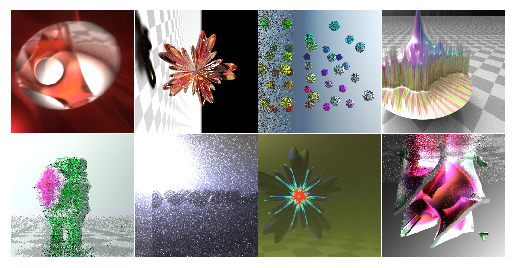

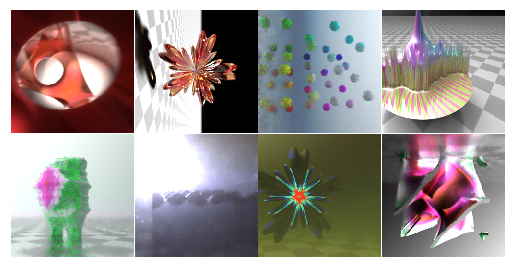

Enable epoch
33 g 1.64123007953167 1.3357334434986115 d 1.3878136664628982 1.3876449912786484 lr 0.002 0.005
34 g 1.3509658545255656 1.2478553801774979 d 1.3873006820678713 1.3872030079364777 lr 0.002 0.005
35 g 1.2608736380934713 1.225108563899994 d 1.3873794376850128 1.3871542513370514 lr 0.002 0.005
36 g 1.237513117492199 1.1946667358279228 d 1.3870949059724804 1.387115940451622 lr 0.002 0.005
37 g 1.2359067305922509 1.1820347011089325 d 1.3870773583650586 1.3869100660085678 lr 0.002 0.005
38 g 1.19025884270668 1.1713423058390617 d 1.3870450317859653 1.386913776397705 lr 0.002 0.005
39 g 1.2407865762710573 1.177153319120407 d 1.3869957119226455 1.387484833598137 lr 0.002 0.005
40 g 1.2369488388299943 1.1554354056715965 d 1.38731095790863 1.387322574853897 lr 0.002 0.005
41 g 1.2039547249674791 1.1542479768395424 d 1.3870384484529497 1.386958822607994 lr 0.002 0.005
42 g 1.2298897340893746 1.1606632247567177 d 1.386858421564102 1.3870184123516083 lr 0.002 0.005
43 g 1.160554321110248

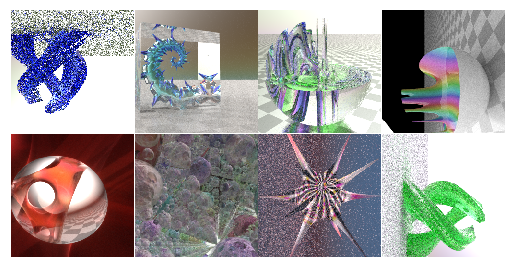

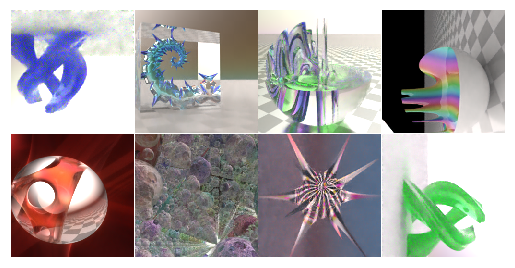

65 g 1.1211357012391088 1.182732105255127 d 1.2271118313074114 1.2267507910728455 lr 0.002 0.005
66 g 1.1376780509948732 1.1503530964255333 d 1.2286357104778287 1.2110460549592972 lr 0.002 0.005
67 g 1.0790537223219874 1.0742947161197662 d 1.2109597027301786 1.1977319121360779 lr 0.002 0.005
68 g 1.151171724498272 1.081639125943184 d 1.2022008657455445 1.1921395808458328 lr 0.002 0.005
69 g 1.12452205568552 1.0693194270133972 d 1.2430671751499174 1.3861082196235657 lr 0.002 0.005
70 g 1.11040163487196 1.109047345817089 d 1.351255738735199 1.2834270149469376 lr 0.002 0.005
71 g 1.1285102188587188 1.0780748203396797 d 1.2496914595365525 1.2123545855283737 lr 0.002 0.005
72 g 1.091396740078926 1.0910656601190567 d 1.2188525140285489 1.1995713710784912 lr 0.002 0.005
73 g 1.3349016457796097 1.1527364552021027 d 1.2254301369190217 1.214869275689125 lr 0.002 0.005
74 g 1.1253557950258255 1.0969231352210045 d 1.2180337667465209 1.1980848610401154 lr 0.002 0.005
75 g 1.1484946191310879 1.08518

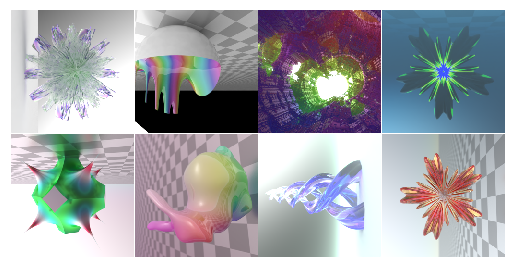

97 g 1.0469593167304991 1.0091399401426315 d 1.3857174068689349 1.3872951865196228 lr 0.002 0.0015
98 g 1.0932958751916888 1.0154016390442848 d 1.387337827682495 1.387310341000557 lr 0.002 0.0015
99 g 1.0691919691860678 1.0004839450120926 d 1.3869608104228976 1.3871092796325684 lr 0.002 0.0015
100 g 1.0550568804144858 1.0376805439591408 d 1.3861624509096144 1.3868988305330276 lr 0.002 0.00045
101 g 1.1414157412946226 1.0075787156820297 d 1.386671483516693 1.3871682584285736 lr 0.002 0.00045
102 g 1.0175611510872837 1.029022067785263 d 1.3862968176603319 1.3872710168361664 lr 0.002 0.00045
103 g 1.0097344890236855 0.9946985654532909 d 1.3860284626483919 1.3871662020683289 lr 0.002 0.00045
104 g 0.9880324274301528 1.0009322576224804 d 1.3865479797124864 1.387208640575409 lr 0.002 0.00045
105 g 1.054152226448059 0.9993165582418442 d 1.3866577476263047 1.3871475756168365 lr 0.002 0.00045
106 g 1.0563773900270461 1.0094915330410004 d 1.3867189139127731 1.387091025710106 lr 0.002 0.00045
107

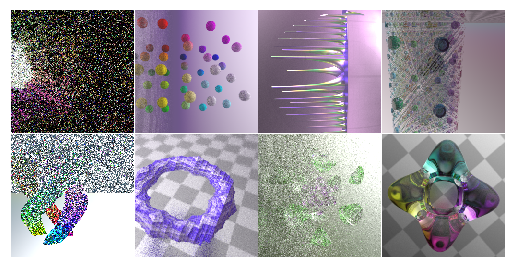

129 g 0.9576336964964864 0.9601048044860363 d 1.3860807955265049 1.3869665712118149 lr 0.002 0.0001
130 g 1.1111183494329453 0.9539482295513153 d 1.3863263577222824 1.3870608061552048 lr 0.002 0.0001
131 g 0.994003066420555 0.9741538017988205 d 1.3864451676607135 1.387002319097519 lr 0.002 0.0001
132 g 1.0081004127860071 0.9763111583888531 d 1.3864605247974398 1.387065276503563 lr 0.002 0.0001
133 g 0.9318065159022804 0.9630542397499084 d 1.3864409983158112 1.3870134353637695 lr 0.002 0.0001
134 g 0.9840073868632315 0.9584663696587086 d 1.3869926631450649 1.3870609253644943 lr 0.002 0.0001
135 g 1.0472247183322907 0.9512570984661579 d 1.3866723477840417 1.3869872391223907 lr 0.002 0.0001
136 g 0.9860334873199463 0.9476330131292343 d 1.3865178912878033 1.3870088905096054 lr 0.002 0.0001
137 g 1.0576512053608897 0.9486687406897545 d 1.3866908699274068 1.3870171010494232 lr 0.002 0.0001
138 g 0.9809952840209006 0.9502127654850483 d 1.3865088045597072 1.3871847689151764 lr 0.002 0.0001
139

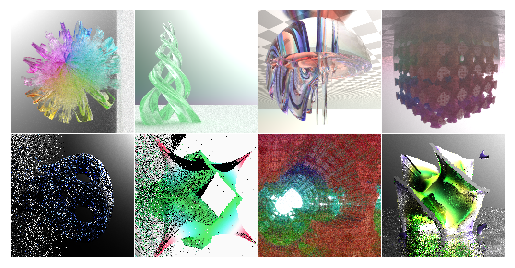

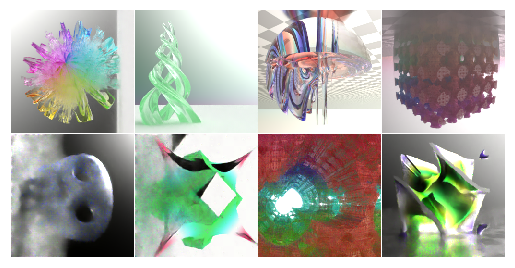

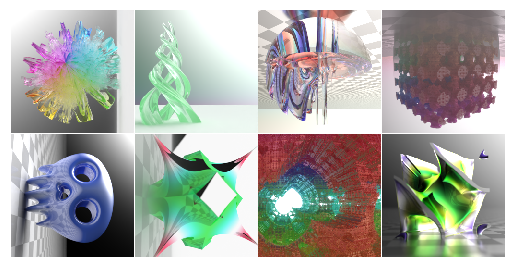

161 g 0.9849227234721186 0.9489875622093678 d 1.3860810905694962 1.3870440572500229 lr 0.002 0.0001
162 g 0.9456094011664392 0.9182541035115719 d 1.386419692635536 1.3868776857852936 lr 0.002 0.0001
163 g 0.9215068347752093 0.930545050650835 d 1.3869363814592361 1.3869859725236893 lr 0.002 0.0001
164 g 0.9957584366202354 0.9521788209676743 d 1.3867993652820587 1.3870407491922379 lr 0.002 0.0001
165 g 0.9993647217750549 0.9493688195943832 d 1.3870573997497555 1.3866495937108994 lr 0.0006 0.0001
166 g 0.9942531421780588 0.9076914116740227 d 1.3862590193748472 1.3868180811405182 lr 0.0006 0.0001
167 g 0.9649956554174424 0.901095911860466 d 1.3861894607543945 1.3868390917778015 lr 0.0006 0.0001
168 g 0.9531280420720575 0.905996885150671 d 1.3867277294397355 1.3868360221385956 lr 0.0006 0.0001
169 g 0.8902865715324877 0.8999880626797676 d 1.3865092009305955 1.3868512064218521 lr 0.0006 0.0001
170 g 0.9351134717464449 0.8956555277109146 d 1.3864312887191772 1.386867269873619 lr 0.0006 0.0001

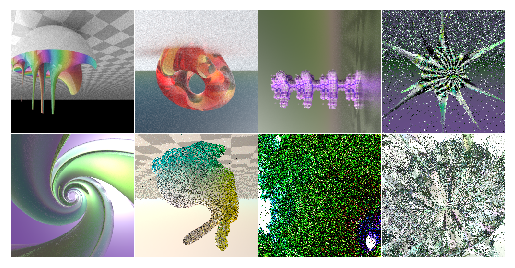

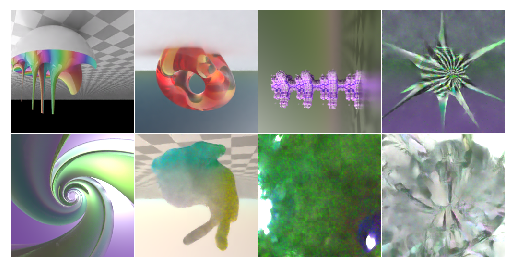

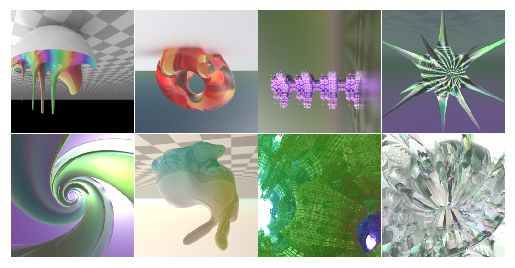

193 g 0.943573060631752 0.8917554244399071 d 1.3866242438554766 1.3867254853248596 lr 0.0006 0.0001
194 g 0.9681298322975636 0.8951329626142979 d 1.3865832984447477 1.3867617696523666 lr 0.0006 0.0001
195 g 0.9466725580394265 0.891472116112709 d 1.3864275485277178 1.3869902789592743 lr 0.0006 0.0001
196 g 1.0744387418031696 0.8908391892910004 d 1.3864793568849563 1.3867106139659882 lr 0.0006 0.0001
197 g 0.9920303478837011 0.9034580700099468 d 1.3864500313997268 1.3866417855024338 lr 0.0006 0.0001
198 g 0.9705981969833373 0.8903731629252434 d 1.3864600956439974 1.3866506218910217 lr 0.0006 0.0001
199 g 0.9041127368807794 0.8872566260397434 d 1.3864318966865539 1.3866694420576096 lr 0.0006 0.0001
200 g 0.90903562605381 0.886842492967844 d 1.3866036951541902 1.3866035640239716 lr 0.0006 0.0001
201 g 0.9898440435528755 0.9046725034713745 d 1.386347505450249 1.3867084234952927 lr 0.00017999999999999998 0.0001
202 g 1.0302384972572325 0.883995495736599 d 1.3862535297870635 1.386673018336296

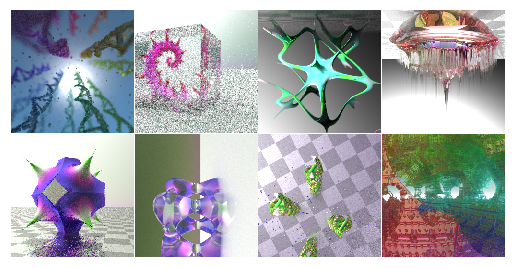

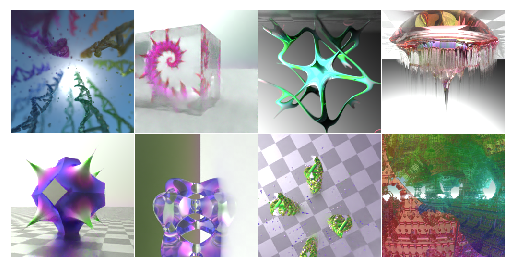

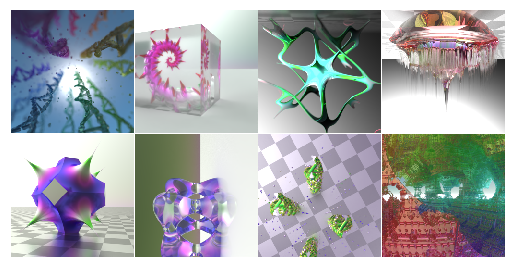

225 g 0.9088918432593345 0.8774387575685978 d 1.386387553811073 1.3866693824529648 lr 0.00017999999999999998 0.0001
226 g 0.973318849503994 0.8788365721702576 d 1.3865394920110703 1.3866444677114487 lr 0.00017999999999999998 0.0001
227 g 0.9708166986703872 0.8816080205142498 d 1.3868483841419226 1.3867100179195404 lr 0.00017999999999999998 0.0001
228 g 0.9223099052906037 0.875910472124815 d 1.3858326375484467 1.3866665363311768 lr 0.00017999999999999998 0.0001
229 g 0.9638251915574074 0.8789069838821888 d 1.3862906575202945 1.3866495192050934 lr 0.00017999999999999998 0.0001
230 g 0.9276176452636719 0.8752883560955524 d 1.3862101435661316 1.3867227584123611 lr 0.00017999999999999998 0.0001
231 g 0.8861374631524087 0.8775136061012745 d 1.3862317830324173 1.386659562587738 lr 0.00017999999999999998 0.0001
232 g 0.9414467275142668 0.8774390183389187 d 1.3859889417886735 1.3866224139928818 lr 0.00017999999999999998 0.0001
233 g 0.9244469165802 0.8753929659724236 d 1.386331996321678 1.38661

In [7]:
discriminator_params = torch.cat([x.view(-1) for x in discriminator.parameters()])

batch_size = 24  # how much RAM do I have?
batch_per_epoch = 40
batch_per_epoch_val = 8

num_epoch = 1024

dataset = RawDataset(batch_size*batch_per_epoch)

valloader = []
for x, y in torch.utils.data.DataLoader(dataset, batch_size=batch_size):
    valloader.append((x, y))
    if len(valloader) >= batch_per_epoch_val:
        break

print("Ready")

for epoch in range(num_epoch):
    if epoch == enable_epoch:
        print("Enable epoch")
        lossfun = CombinedLoss(1.0, 1.0, 1.0, 0.2, device)
        from collections import defaultdict
        optimizer.__setstate__({'state': defaultdict(dict)})
        optimizer_d.__setstate__({'state': defaultdict(dict)})

    # training
    trainloader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True)
    mean_loss_g, mean_loss_d = 0.0, 0.0
    for x, y in trainloader:
        x = x.to(device)
        y = y.to(device)
        x = torch.log(1+x)
        y = torch.log(1+y)

        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Update Discriminator
        optimizer_d.zero_grad()
        real_outputs = discriminator(y)
        d_loss_real = lossfun(None, real_labels, real_outputs, is_discriminator=True)

        fake_images = model(x)
        fake_outputs = discriminator(fake_images.detach())
        d_loss_fake = lossfun(None, fake_labels, fake_outputs, is_discriminator=True)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        regl2 = 1.0 * torch.mean((discriminator_params)**2)
        regl2.backward()
        optimizer_d.step()

        # Update Generator
        optimizer.zero_grad()
        fake_outputs = discriminator(fake_images)
        g_loss = lossfun(fake_images, y, fake_outputs)
        g_loss.backward()
        optimizer.step()

        mean_loss_g += g_loss.item() / batch_per_epoch
        mean_loss_d += d_loss.item() / batch_per_epoch
    
    # validation
    mean_loss_gv, mean_loss_dv = 0.0, 0.0
    with torch.no_grad():
        for x, y in valloader:
            x = x.to(device)
            y = y.to(device)
            x = torch.log(1+x)
            y = torch.log(1+y)

            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            real_outputs = discriminator(y)
            d_loss_real = lossfun(None, real_labels, real_outputs, is_discriminator=True)

            fake_images = model(x)
            fake_outputs = discriminator(fake_images)
            d_loss_fake = lossfun(None, fake_labels, fake_outputs, is_discriminator=True)

            d_loss = d_loss_real + d_loss_fake
            g_loss = lossfun(fake_images, y, fake_outputs)

            mean_loss_gv += g_loss.item() / batch_per_epoch_val
            mean_loss_dv += d_loss.item() / batch_per_epoch_val
    
    # scheduling / verbose
    epoch += 1
    if epoch > enable_epoch:
        scheduler.step(mean_loss_gv)
        scheduler_d.step(mean_loss_dv)
        if scheduler.get_last_lr()[0] <= scheduler.min_lrs[0]:
            break
        print(f"{epoch} g {mean_loss_g} {mean_loss_gv} d {mean_loss_d} {mean_loss_dv} lr {scheduler.get_last_lr()[0]} {scheduler_d.get_last_lr()[0]}")
    else:
        print(f"{epoch} g {mean_loss_g} {mean_loss_gv} d {mean_loss_d} {mean_loss_dv}")
    torch.save(model, "resunet3_1_x.pth")
    torch.save(discriminator, "resunet3_1_xd.pth")
    if epoch % 32 == 0:
        loader = torch.utils.data.DataLoader(dataset, batch_size=8)
        for x, y in loader:
            with torch.no_grad():
                x1 = torch.log(1+x.to(device))
                y1 = torch.exp(model(x1))-1
            plot_imgs(x)
            plot_imgs(y1)
            plot_imgs(y)
            break

print("Done")